# Introdução ao Tensorflow e classificação de imagens

### Artur Rodrigues Rocha Neto

Esse notebook é uma experimentação inicial com a biblioteca de aprendizagem profunda Tensorflow. Seguirei o tutorial para iniciantes do [site da biblioteca](https://www.tensorflow.org/tutorials/quickstart/beginner), mas com algumas pequenas diferenças ao longo do caminho. Depois, passarei a seguir o [tutorial específico para CNNs](https://www.tensorflow.org/tutorials/images/cnn), também com minhas próprias mudanças a medida que eu quiser explorar detalhes da biblioteca não contemplados nesses guias. O dataset do tutorial de CNNs é o CIFAR10, mas continuarei usando o MNIST. Também não usarei a estrutura pré-compilada disponível no pacote `tf.keras.datasets`, e sim o disponível no [Kaggle](https://www.kaggle.com/c/digit-recognizer/data). Por fim, pretendo gerar uma arquitetura de rede tal como a do artigo [Convolutional Neural Networks for No-Reference Image Quality Assessment](https://ieeexplore.ieee.org/document/6909620), e então eu trocarei de dataset e passarei a usar o TID2008.

Vamos começar importando todos os pacotes necessários para início de investigação.

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf

Agora, vamos carregar os dados de treino e teste e armazená-los em um conjunto completo cada no formato esperado pelo Tensorflow.

In [24]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

y_train = train_set["label"]
train_set = train_set.drop(["label"], axis=1)

load_image = lambda row : np.array(row).reshape(28, 28) / 255.0
X_train = np.array([load_image(row) for index, row in train_set.iterrows()])
X_test = np.array([load_image(row) for index, row in test_set.iterrows()])

print(f"Dimensões do conjunto de treinamento: {X_train.shape}")
print(f"Dimensões do conjunto de teste: {X_test.shape}")

Dimensões do conjunto de treinamento: (42000, 28, 28)
Dimensões do conjunto de teste: (28000, 28, 28)


Um vez com os conjuntos de treino e teste prontos, é hora de montar nossa rede. Vamos montar um modelo sequencial a partir da classe `tf.keras.Sequential`, a qual agrupa uma sequência de diferentes camadas que compoêm a rede final. Os tipos de camadas disponíveis ficam guardados no módulo `tf.keras.layers`. Os outros três elementos básicos são a função de otimização (no caso Adam), a função de perda e qual métrica será usada para calibrar o modelo; a função de perda escolhida foi a entropia cruzada esparsa (as funções de perda disponíveis estão no módulo `tf.keras.losses`) e a métrica objetivo será a acurácia. Uma vez com o modelo montado, podemos ajustá-lo com o conjunto de treinamento chamando `.fit()`. Podemos capturar o retorno de `.fit()` para visualizar a evolução do ajuste (ver próxima parte).

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, use_multiprocessing=True)

Epoch 1/10
1313/1313 [==============================] - 1s 674us/step - loss: 0.5423 - accuracy: 0.8408
Epoch 2/10
1313/1313 [==============================] - 1s 684us/step - loss: 0.1718 - accuracy: 0.9486
Epoch 3/10
1313/1313 [==============================] - 1s 686us/step - loss: 0.1236 - accuracy: 0.9638
Epoch 4/10
1313/1313 [==============================] - 1s 756us/step - loss: 0.0960 - accuracy: 0.9703
Epoch 5/10
1313/1313 [==============================] - 1s 698us/step - loss: 0.0833 - accuracy: 0.9733
Epoch 6/10
1313/1313 [==============================] - 1s 739us/step - loss: 0.0685 - accuracy: 0.9780
Epoch 7/10
1313/1313 [==============================] - 1s 722us/step - loss: 0.0588 - accuracy: 0.9821
Epoch 8/10
1313/1313 [==============================] - 1s 711us/step - loss: 0.0564 - accuracy: 0.9816
Epoch 9/10
1313/1313 [==============================] - 1s 710us/step - loss: 0.0466 - accuracy: 0.9846
Epoch 10/10
1313/1313 [==============================] - 1s 748u

Agora, podemos classificar novas observações chamando o método `.predict()` do modelo ajustado. O retorno é um conjunto de logits, ou seja, probabilidades inversas de cada observação pertencer a cada classe. Para transformar essa informação em etiquetas, primeiro convertemos os logits para probabilidades, depois encontramos a maior delas no conjunto e retemos o índice sequencial dele, que nesse problema específico indica univocamente a classe de dígito. Como bônus, salvei o resultado e submeti na competição introdutória no Kaggle.

In [72]:
y_pred = model.predict(X_test, use_multiprocessing=True)
y_pred = tf.nn.softmax(y_pred)
y_pred = tf.argmax(y_pred, axis=1).numpy()

sub = pd.DataFrame({"ImageId" : list(range(1, X_test.shape[0]+1)), "Label" : list(y_pred)})
sub.to_csv("tutu_submission_simples.csv", index=None)

Vamos agora seguir o tutorial sobre CNNs e montar um novo modelo, mas ainda usando o dataset MNIST. Classificaremos o mesmo conjunto de testes novamente e submeteremos ao Kaggle, verificando se a nova arquitetura de rede representou algum ganho nesse problema específico.

A arquitetura convolucional mais simples é definida como uma sequência de convoluções e reduções de dimensionalidade. Como nosso dataset não o mesmo do tutorial, as dimensões das camadas de convolução serão diferentes.

In [62]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(28, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(56, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(56, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(56, activation="relu"),
    tf.keras.layers.Dense(10),
])

Nosso modelo está pronto para ser compilado (definição de otimizador, função de perda e métrica e ajuste) e, finalimente, ajustado com o conjunto de treinamento.

In [64]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, use_multiprocessing=True)

Epoch 1/10
1313/1313 [==============================] - 1s 680us/step - loss: 0.0411 - accuracy: 0.9852
Epoch 2/10
1313/1313 [==============================] - 1s 677us/step - loss: 0.0354 - accuracy: 0.9878
Epoch 3/10
1313/1313 [==============================] - 1s 686us/step - loss: 0.0350 - accuracy: 0.9886
Epoch 4/10
1313/1313 [==============================] - 1s 710us/step - loss: 0.0342 - accuracy: 0.9886
Epoch 5/10
1313/1313 [==============================] - 1s 676us/step - loss: 0.0297 - accuracy: 0.9901
Epoch 6/10
1313/1313 [==============================] - 1s 670us/step - loss: 0.0297 - accuracy: 0.9898
Epoch 7/10
1313/1313 [==============================] - 1s 678us/step - loss: 0.0263 - accuracy: 0.9903
Epoch 8/10
1313/1313 [==============================] - 1s 678us/step - loss: 0.0256 - accuracy: 0.9914
Epoch 9/10
1313/1313 [==============================] - 1s 689us/step - loss: 0.0213 - accuracy: 0.9929
Epoch 10/10
1313/1313 [==============================] - 1s 674u

Vamos usar a variável `history` para visualizar a evolução das métricas de ajuste ao longo da etapa de treinamento da rede.

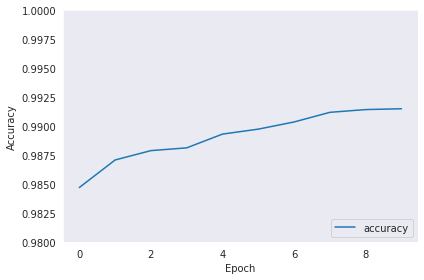

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("dark")

plt.plot(history.history["accuracy"], label="accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.98, 1])
plt.legend(loc="lower right")
plt.tight_layout()

Por fim, vamos gerar um conjunto de predições tal como fizeomos para a primeia rede.

In [73]:
y_pred = model.predict(X_test, use_multiprocessing=True)
y_pred = tf.nn.softmax(y_pred)
y_pred = tf.argmax(y_pred, axis=1).numpy()

sub = pd.DataFrame({"ImageId" : list(range(1, X_test.shape[0]+1)), "Label" : list(y_pred)})
sub.to_csv("tutu_submission_cnn.csv", index=None)